# Read cleaned Input files

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math
import json
get_ipython().run_line_magic('matplotlib', 'inline')

# read in the json files
portfolio = pd.read_json('data/portfolio_clean.json', orient='records', lines=True)
profile = pd.read_json('data/new_profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript_profile_merge.json', orient='records', lines=True)

# Data Exploration & Visualization

In [2]:
profile.describe()

,income,age,became_member_on,days_being_members
count,14825.000000,14825.000000,1.482500e+04,14825.000000
mean,65404.991568,54.393524,2.016689e+07,1780.478988
std,21598.299410,17.383705,1.188565e+04,419.205158
min,30000.000000,18.000000,2.013073e+07,1258.000000
25%,49000.000000,42.000000,2.016052e+07,1466.000000
50%,64000.000000,55.000000,2.017080e+07,1616.000000
75%,80000.000000,66.000000,2.017123e+07,2055.000000
max,120000.000000,101.000000,2.018073e+07,3081.000000


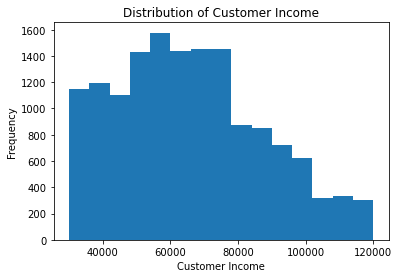

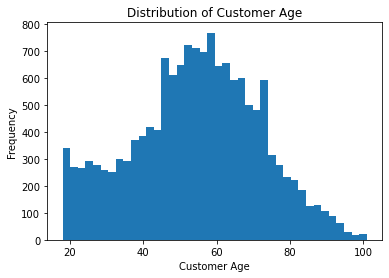

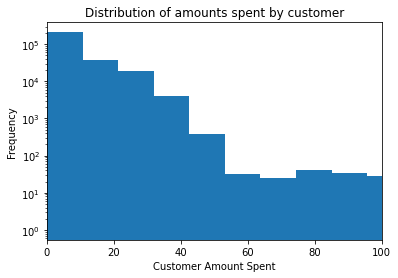

In [113]:
def plot_customer_data():
    '''Plot customer income and age data'''
    
    # Plot histogram of user income
    customer_income = profile['income'].plot(kind='hist', bins=15, title='Distribution of Customer Income')
    customer_income.set_xlabel("Customer Income")
    plt.savefig('img/Distribution_of_Customer_Income.png')
    # Plot histogram of customer age
    plt.figure()
    customer_age = profile['age'].plot(kind='hist', bins=40, title='Distribution of Customer Age')
    customer_age.set_xlabel("Customer Age")
    plt.savefig('img/Distribution_of_Customer_Age.png')
    plt.figure()
    costumer_amount = transcript['amount'].plot(kind='hist', bins=100,logy=True,xlim=(0,100),title='Distribution of amounts spent by customer');
    costumer_amount.set_xlabel("Customer Amount Spent")
    plt.savefig('img/Distribution_of_amounts_spent_by_customer.png')
    
plot_customer_data()

* Sample mean age is 54 years. Sample has a relatively normal distribuion.
* Sample Mean income is arround 65000. 
* The mayority of the transactions done in Starbucks are between 0 and 30.

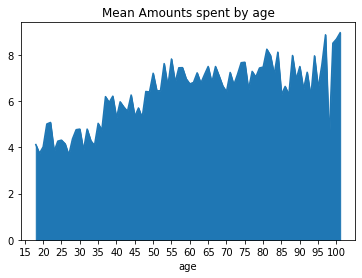

In [117]:
age_amount = transcript.groupby(['age'])['amount'].agg('mean')
age_amount.plot.area(xticks=(np.arange(15,105,5)),title='Mean Amounts spent by age');
plt.savefig('img/Mean_Amounts_spent_by_age.png')

* Ammount spent seems to be proportional to the age (higher the age, higher the ammount spent) 

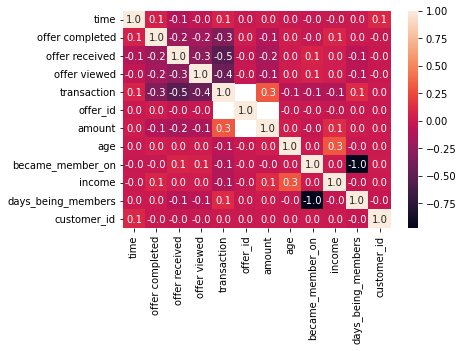

In [5]:
import seaborn as sns 
sns.heatmap(transcript.corr(),annot=True,fmt='.1f'); # see the correlation of each qualitative variable

* No strong correlation is seen between parameters

In [6]:
transcript.head()

,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,gender,age,became_member_on,income,days_being_members,customer_id
0,offer received,0,0,1,0,0,3.0,0.00,F,75,20170509,100000,1701,1
1,offer viewed,6,0,0,1,0,3.0,0.00,F,75,20170509,100000,1701,1
2,transaction,132,0,0,0,1,NaN,19.89,F,75,20170509,100000,1701,1
3,offer completed,132,1,0,0,0,3.0,0.00,F,75,20170509,100000,1701,1
4,transaction,144,0,0,0,1,NaN,17.78,F,75,20170509,100000,1701,1


In [7]:
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


# Recomendation Engine

In [8]:
def create_costumer_matrix(offer_customer, filename):
    '''
    Return the costumer matrix that indicate the number of offer completed of each user
    
    Inputs:
    offer - a cleaned transcript dataframe
    filename [string] - the file name that save the costumer_matrix
    
    Output:
    user_item_matrix - the costumer_matrix 
        - row = customer 
        - column = offer
        - value is the number of offer completed by the user 
            - NaN means no offer given to this customer
    
    '''
    # create an empty matrix
    costumer_matrix = offer_customer.groupby(['customer_id', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # use bogo and discount offer type only
    costumer_matrix.drop(list(portfolio[portfolio['offer_type']=='informational'].index), axis=1, inplace=True)
    
    for offer_id in costumer_matrix.columns:
        print("Offer id: %i"  %(offer_id))
        for customer in costumer_matrix.index:
            events = []
            for event in offer_customer[(offer_customer['offer_id']==offer_id) & (offer_customer['customer_id']==customer)]['event']:
                events.append(event)
            if len(events) >= 3:
                costumer_matrix.loc[customer, offer_id] = 0
                for i in range(len(events) - 2):
                    # If teh sequence is offer recieved -> offer viewed -> offer completed, this will mean that the offer was usefull
                    # Transaction is not used since its not linked with the offers
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        costumer_matrix.loc[customer, offer_id] += 1
            elif len(events) > 0:
                costumer_matrix.loc[customer, offer_id] = 0
    
    # store the martix into pickle file
    fh = open(filename, 'wb')
    pickle.dump(costumer_matrix,fh)
    fh.close()
    print("Done")
    
    return costumer_matrix

In [10]:
full_offer_customer = transcript[['event', 'customer_id','offer_id','time']].sort_values('time')
# Divide into Train and Test DF
train_offer_customer = full_offer_customer[:int(full_offer_customer.shape[0]*0.7)]
test_offer_customer = full_offer_customer[int(full_offer_customer.shape[0]*0.7):]

In [11]:
full_customer_matrix = create_costumer_matrix(full_offer_customer, 'full_customer_matrix.p')
train_customer_matrix = create_costumer_matrix(train_offer_customer, 'train_customer_matrix.p')
test_customer_matrix = create_costumer_matrix(test_offer_customer, 'test_customer_matrix.p')

Offer id: 0
Offer id: 1
Offer id: 3
Offer id: 4
Offer id: 5
Offer id: 6
Offer id: 8
Offer id: 9
Done
Offer id: 0
Offer id: 1
Offer id: 3
Offer id: 4
Offer id: 5
Offer id: 6
Offer id: 8
Offer id: 9
Done
Offer id: 0
Offer id: 1
Offer id: 3
Offer id: 4
Offer id: 5
Offer id: 6
Offer id: 8
Offer id: 9
Done


In [12]:
train_customer_matrix

offer_id,0.0,1.0,3.0,4.0,5.0,6.0,8.0,9.0
customer_id,,,,,,,,
1,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN
2,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0
3,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0
4,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN
5,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
14820,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
14821,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14822,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
def FunkSVD(full_mat, latent_features=5, learning_rate=0.0001, iters=250):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    Inputs:
    full_mat - [numpy array] a matrix with customers as rows, offers as columns, and offer completed as values
    latent_features - [int] the number of latent features used
    learning_rate - [float] the learning rate 
    iters - [int] the number of iterations
    
    Outputs:
    customer_mat - [numpy array] a customer by latent feature matrix
    offer_mat - [numpy array] a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_customer = full_mat.shape[0]
    n_offers = full_mat.shape[1]
    num_full = np.count_nonzero(~np.isnan(full_mat))
    
    # initialize the user and movie matrices with random values
    customer_mat = np.random.rand(n_customer, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Iteration  Acumulative Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each customer offer pair
        for i in range(n_customer):
            for j in range(n_offers):
                
                # if the rating exists
                if full_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = full_mat[i, j] - np.dot(customer_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        customer_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*customer_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_full))
        
    return customer_mat, offer_mat 

In [14]:
# Create user-by-item matrix - nothing to do here
full_customer_matrix_np = np.array(full_customer_matrix)
train_customer_matrix_np = np.array(train_customer_matrix)
# Fit FunkSVD with the specified hyper parameters to the training data
full_customer_mat, full_offer_mat = FunkSVD(full_customer_matrix_np, latent_features=15, learning_rate=0.005, iters=200)
train_customer_mat, train_offer_mat = FunkSVD(train_customer_matrix_np, latent_features=15, learning_rate=0.005, iters=200)

Iteration  Acumulative Mean Squared Error 
1 		 0.345656
2 		 0.304630
3 		 0.304114
4 		 0.303585
5 		 0.303049
6 		 0.302504
7 		 0.301952
8 		 0.301390
9 		 0.300818
10 		 0.300235
11 		 0.299642
12 		 0.299035
13 		 0.298416
14 		 0.297782
15 		 0.297132
16 		 0.296466
17 		 0.295783
18 		 0.295079
19 		 0.294355
20 		 0.293609
21 		 0.292839
22 		 0.292044
23 		 0.291220
24 		 0.290368
25 		 0.289483
26 		 0.288565
27 		 0.287611
28 		 0.286618
29 		 0.285583
30 		 0.284505
31 		 0.283380
32 		 0.282205
33 		 0.280977
34 		 0.279693
35 		 0.278349
36 		 0.276942
37 		 0.275469
38 		 0.273925
39 		 0.272308
40 		 0.270613
41 		 0.268838
42 		 0.266977
43 		 0.265028
44 		 0.262988
45 		 0.260852
46 		 0.258619
47 		 0.256284
48 		 0.253845
49 		 0.251300
50 		 0.248648
51 		 0.245886
52 		 0.243014
53 		 0.240032
54 		 0.236939
55 		 0.233737
56 		 0.230426
57 		 0.227010
58 		 0.223491
59 		 0.219872
60 		 0.216159
61 		 0.212355
62 		 0.208468
63 		 0.204502
64 		 0.200465
65 		 

## Validate Recomendation Model

In [15]:
def cutomer_reaction_pred(customer_matrix,offer_matrix,customer_id,offer_id):
    ''' predict how customers will react to an offer'''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        customer_ids_series = np.array(train_customer_matrix.index)
        offer_ids_series = np.array(train_customer_matrix.columns)
        # Customer row and offer Column
        customer_row = np.where(customer_ids_series == customer_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]
        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(customer_matrix[customer_row, :], offer_matrix[:, offer_col])
        return pred
    except:
        # Customer does not exist in our data, predictions can't be done        
        return None

def print_prediction_summary(customer_id, offer_id, prediction,train_customer_matrix):
    '''
    Prints predicted data compared with actual data
    '''
    actual_val = train_customer_matrix[offer_id][customer_id]
    predicted_val = prediction
    print("For customer {} we predict a {} for offer {}.".format(customer_id, round(prediction, 2), str(offer_id)))
    print("For customer {} actual value is {} for offer {}.".format(customer_id, round(actual_val, 2), str(offer_id)))

# validate predicted value for customer_id 3 and offer id 8
pred_cust3_offer8 = cutomer_reaction_pred(train_customer_mat,train_offer_mat,3,8)
print_prediction_summary(3, 8, pred_cust3_offer8,train_customer_matrix)

For customer 3 we predict a 0.97 for offer 8.
For customer 3 actual value is 1.0 for offer 8.


In [16]:
def validation_comparison(test_customer_matrix, train_customer_mat, train_offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_customer_matrix))
    
    sse_accum = 0
    
    for customer_id in test_customer_matrix.index:
        for offer_id in test_customer_matrix.columns:
            if ~np.isnan(test_customer_matrix.loc[customer_id, offer_id]):
                predict_value = cutomer_reaction_pred(train_customer_mat, train_offer_mat, customer_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_customer_matrix.loc[customer_id, offer_id] - cutomer_reaction_pred(train_customer_mat, train_offer_mat, customer_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [17]:
# Evaluation for latent features of 15
validation_comparison(test_customer_matrix, train_customer_mat, train_offer_mat)

0.29579248190224045


## Recomendations concernig the entire sample 
* Defined by the amount of revenue each offer provided. 

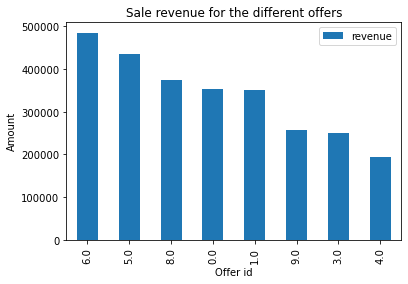

In [18]:
def best_offers(customer_matrix,plot=True):
    '''
    Find the offer that generates more revenew
    '''
    offer_gain = []
    for offer_id in customer_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['customer_id'].isin(list(customer_matrix[customer_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['amount'].sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'revenue'])
    offer_value['revenue'] = pd.to_numeric(offer_value['revenue'])
    offer_value.sort_values(by='revenue', ascending=False, inplace=True)
    if plot== True:
        best_sale = offer_value.plot('offer_id','revenue',kind='bar', title='Sale revenue for the different offers')
        best_sale.set_xlabel('Offer id')
        best_sale.set_ylabel('Amount')
    
    return offer_value
best_offer_revenue = best_offers(full_customer_matrix)

In [99]:
def gender_vs_offertype(full_customer_matrix):

    gender_df = transcript[['customer_id','gender']].groupby('customer_id').min()
    acummulative_gender = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['F', 'M', 'O'], columns=['bogo', 'discount'])
    offer_type_df=portfolio[['bogo','discount']]

    for customer_id in full_customer_matrix.index:
        row = full_customer_matrix.loc[customer_id]
        for offer_id in full_customer_matrix.columns:
            offer = row[offer_id]
            if offer>=1:
                if offer_type_df.loc[offer_id]['bogo']==1:
                    offer_type ='bogo' 
                elif offer_type_df.loc[offer_id]['discount']==1: 
                    offer_type ='discount'
                gen = gender_df.loc[customer_id]['gender']
                acummulative_gender.loc[gen][offer_type] += 1

        
    return acummulative_gender
g_vs_offer_abs = gender_vs_offertype(full_customer_matrix)

* Reaction of type of offer depending on the gender of the customer

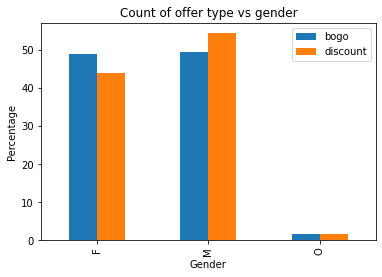

In [109]:
g_vs_offer_perc = g_vs_offer_abs/g_vs_offer_abs.sum() *100
g_vs_offer_plot = g_vs_offer_perc.plot(kind='bar',title='Count of offer type vs gender');
g_vs_offer_plot.set_xlabel("Gender");
g_vs_offer_plot.set_ylabel("Percentage");

## Recomendation for old and new customers
* Defined using the FunkSVD matrix defined earlier.

In [19]:
def recommend_offer(customer_id, train_customer_mat, train_offer_mat):
    recommendation = {}
    for offer_id in train_customer_matrix.columns:
        pred_val = cutomer_reaction_pred(train_customer_mat, train_offer_mat, customer_id, offer_id)
        if pred_val != None:
            recommendation[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("This customer is not in our database, recomended offers are the offers having the best sales.")
        top_offer = best_offers(full_customer_matrix,False)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("Recommend offer for customer ", customer_id)
        for offer_id, pred_val in sorted(recommendation.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " prediction: ", round(pred_val,2))



In [20]:
# recommend offer for a particular user
recommend_offer(15000, train_customer_mat, train_offer_mat)

This customer is not in our database, recomended offers are the offers having the best sales.
offer id:  6.0
offer id:  5.0
offer id:  8.0
offer id:  0.0
offer id:  1.0
offer id:  9.0
offer id:  3.0
offer id:  4.0


In [21]:
# recommend offer for a particular user
recommend_offer(3, train_customer_mat, train_offer_mat)

Recommend offer for customer  3
offer id:  5.0  prediction:  2.17
offer id:  6.0  prediction:  1.37
offer id:  9.0  prediction:  1.08
offer id:  8.0  prediction:  0.97
offer id:  3.0  prediction:  0.93
offer id:  4.0  prediction:  0.26
offer id:  0.0  prediction:  0.01
offer id:  1.0  prediction:  -0.18
